## Binary and multi-class  classification CNN 

### Binary classification (non-agumented data):

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

In [6]:
#loading pickle file
with open('Oxford-IIIT-Pet_Dics.p', 'rb') as f:
    pickle1 = pickle.load(f)

classDic=pickle1["classDic"]
filesDic=pickle1["filesDic"]

In [7]:
#setting necessary variables
BASE_PATH = "images/"
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001
PLOTS_DPI = 200

In [8]:
#Loading images to predefined shape and applying padding to avoid distortion.

imageData = []

for name in filesDic.keys():
    img = load_img(BASE_PATH+name)
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData.shape

(7390, 200, 200, 3)

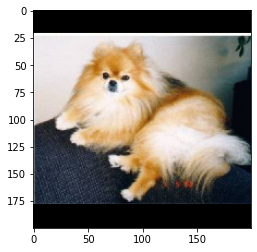

{'species': 'dog',
 'breed': 'pomeranian',
 'target': 16,
 'imgDim': (236, 300, 3),
 'bndBox': [82, 12, 67, 75],
 'foldTrain': True}

In [9]:
#now we have all images in array
#image example:
index=5624
plt.imshow(imageData[index])
plt.show()
list(filesDic.values())[index]#.get("species")

In [10]:
#spliting images into training and testing array defined by pickle file
#adding target array(y) for multiclass classification and binary classification
imageTrain=[]
binaryClassLabelTrain=[]
multiClassLabelTrain=[]
imageTest=[]
binaryClassLabelTest=[]
multiClassLabelTest=[]
for i in range(0,len(filesDic)):
    if(list(filesDic.values())[i].get("foldTrain")):
        imageTrain.append(imageData[i])
        multiClassLabelTrain.append(list(filesDic.values())[i].get("target"))
        if(list(filesDic.values())[i].get("species")=='cat'):
            binaryClassLabelTrain.append(0)
        else:
            binaryClassLabelTrain.append(1)
    else:
        imageTest.append(imageData[i])
        multiClassLabelTest.append(list(filesDic.values())[i].get("target"))
        if(list(filesDic.values())[i].get("species")=='cat'):
            binaryClassLabelTest.append(0)
        else:
            binaryClassLabelTest.append(1)
        
imageTrain=np.array(imageTrain)
imageTest=np.array(imageTest)
binaryClassLabelTrain=np.array(binaryClassLabelTrain)
binaryClassLabelTest=np.array(binaryClassLabelTest)
multiClassLabelTest=np.array(multiClassLabelTest)
multiClassLabelTrain=np.array(multiClassLabelTrain)

print(imageTrain.shape)
print(binaryClassLabelTrain.shape)

(3686, 200, 200, 3)
(3686,)


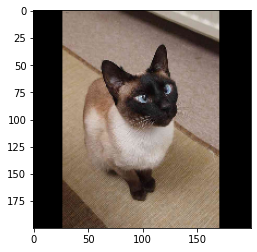

0

In [7]:
#example of a image and its binary label
index=1000
plt.imshow(imageTrain[index])
plt.show()
binaryClassLabelTrain[index]

In [8]:
#spliting trainig set into traing set and validation set 
imageTrain, imageValidation, binaryClassLabelTrain, binaryClassLabelValidation=train_test_split(imageTrain,
                                                                                              binaryClassLabelTrain,
                                                                                              test_size=0.2,
                                                                                              random_state = 5,
                                                                                              stratify = binaryClassLabelTrain
                                                                                             )

In [9]:
#agumenting images using ImageDataGenerator and creating images tensors
train_gen_agumented = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data_agumented = train_gen_agumented.flow(x = imageTrain, y = binaryClassLabelTrain, batch_size = BATCH_SIZE, shuffle = True)
len(train_data_agumented)

93

In [10]:
#using image data generator on all the data so we have all data as image tensor
train_gen = ImageDataGenerator(rescale = 1./255)
validation_data = train_gen.flow(x = imageValidation, y = binaryClassLabelValidation, batch_size = BATCH_SIZE, shuffle = True)
len(validation_data)

24

In [11]:
train_gen = ImageDataGenerator(rescale = 1./255)
train_data = train_gen.flow(x = imageTrain, y = binaryClassLabelTrain, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

93

In [12]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = imageTest, y = binaryClassLabelTest, batch_size = BATCH_SIZE)
len(test_data)

116

In [13]:
#building a model
cnn=models.Sequential()
cnn.add(layers.Conv2D(32, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3)))
cnn.add(layers.Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.Conv2D(32, 4, padding = 'same'))
cnn.add(layers.Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
   
cnn.add(layers.Conv2D(64, 4, padding = 'same'))
cnn.add(layers.Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.BatchNormalization())
cnn.add(layers.Conv2D(64, 3, padding = 'same'))
cnn.add(layers.Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())

cnn.add(layers.Conv2D(128, 3, padding = 'same'))
cnn.add(layers.Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.Conv2D(128, 2, padding = 'same'))
cnn.add(layers.Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
        
cnn.add(layers.Conv2D(200, 2, padding = 'same'))
cnn.add(layers.Conv2D(200, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())

cnn.add(layers.Flatten())
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(400, activation = 'sigmoid'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(200, activation = 'sigmoid'))
cnn.add(layers.Dropout(0.1))
cnn.add(layers.Dense(2, activation = 'softmax'))
        
#I have been trying to use binary_categorical_acurracy to compile the model but had some problems.
#So at the end I kept it same sparse_categorical_crossentropy as I used for multiclass classification.
cnn.compile(optimizer = Adam(LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      16416     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                    

In [14]:
#training a model with non-agumented data
history_binary = cnn.fit(train_data, validation_data=validation_data, epochs = 60, verbose = 1)

Epoch 1/60
93/93 [==============================] - 489s 5s/step - loss: 0.6533 - sparse_categorical_accuracy: 0.6353 - val_loss: 0.6301 - val_sparse_categorical_accuracy: 0.6775
Epoch 2/60
93/93 [==============================] - 447s 5s/step - loss: 0.5836 - sparse_categorical_accuracy: 0.6876 - val_loss: 0.6430 - val_sparse_categorical_accuracy: 0.6775
Epoch 3/60
93/93 [==============================] - 439s 5s/step - loss: 0.5635 - sparse_categorical_accuracy: 0.7123 - val_loss: 0.6535 - val_sparse_categorical_accuracy: 0.6775
Epoch 4/60
93/93 [==============================] - 443s 5s/step - loss: 0.5084 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.6171 - val_sparse_categorical_accuracy: 0.6843
Epoch 5/60
93/93 [==============================] - 442s 5s/step - loss: 0.4738 - sparse_categorical_accuracy: 0.7717 - val_loss: 0.5850 - val_sparse_categorical_accuracy: 0.6992
Epoch 6/60
93/93 [==============================] - 460s 5s/step - loss: 0.4256 - sparse_categorical_accu

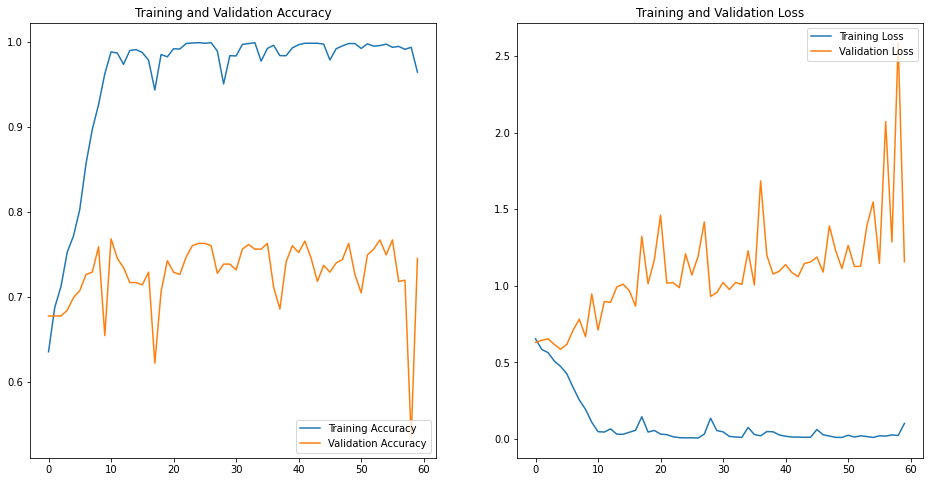

In [16]:
#results:
acc = history_binary.history['sparse_categorical_accuracy']
val_acc = history_binary.history['val_sparse_categorical_accuracy']

loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = history_binary.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

The accuracy and loss graphs are not looking good, the problme might be overfitting, we can see that in accuracy difference between training and validation. 

In [17]:
test_loss, test_acc = cnn.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 0.9976004362106323
Accuracy on Testing data: 0.7853671908378601


In [15]:
y_pred = np.argmax(cnn.predict(imageTest/255), axis = 1)

In [16]:
print(confusion_matrix(binaryClassLabelTest, y_pred))

[[ 651  561]
 [ 234 2258]]


Results showed that there are quite some images classified wrong, mostly cats(probably because there is more dog images).

## Binary classification (agumneted data):

In [21]:
#building a model
cnn=models.Sequential()
cnn.add(layers.Conv2D(32, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3)))
cnn.add(layers.Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.Conv2D(32, 4, padding = 'same'))
cnn.add(layers.Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
   
cnn.add(layers.Conv2D(64, 4, padding = 'same'))
cnn.add(layers.Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.BatchNormalization())
cnn.add(layers.Conv2D(64, 3, padding = 'same'))
cnn.add(layers.Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())

cnn.add(layers.Conv2D(128, 3, padding = 'same'))
cnn.add(layers.Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.Conv2D(128, 2, padding = 'same'))
cnn.add(layers.Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
        
cnn.add(layers.Conv2D(200, 2, padding = 'same'))
cnn.add(layers.Conv2D(200, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())

cnn.add(layers.Flatten())
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(400, activation = 'sigmoid'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(200, activation = 'sigmoid'))
cnn.add(layers.Dropout(0.1))
cnn.add(layers.Dense(2, activation = 'softmax'))
        
cnn.compile(optimizer = Adam(LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 200, 200, 32)      2432      
                                                                 
 conv2d_15 (Conv2D)          (None, 200, 200, 32)      25632     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 100, 100, 32)      16416     
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 32)      16416     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [22]:
#training data with agumented dataset
history_binary_agumented = cnn.fit(train_data_agumented, validation_data=validation_data, epochs = 60, verbose = 1)

Epoch 1/60
93/93 [==============================] - 463s 5s/step - loss: 0.6276 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.6455 - val_sparse_categorical_accuracy: 0.6775
Epoch 2/60
93/93 [==============================] - 460s 5s/step - loss: 0.5986 - sparse_categorical_accuracy: 0.6716 - val_loss: 0.6198 - val_sparse_categorical_accuracy: 0.6775
Epoch 3/60
93/93 [==============================] - 473s 5s/step - loss: 0.5842 - sparse_categorical_accuracy: 0.6900 - val_loss: 0.6016 - val_sparse_categorical_accuracy: 0.6789
Epoch 4/60
93/93 [==============================] - 466s 5s/step - loss: 0.5862 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.6037 - val_sparse_categorical_accuracy: 0.6789
Epoch 5/60
93/93 [==============================] - 465s 5s/step - loss: 0.5673 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.6269 - val_sparse_categorical_accuracy: 0.6829
Epoch 6/60
93/93 [==============================] - 476s 5s/step - loss: 0.5578 - sparse_categorical_accu

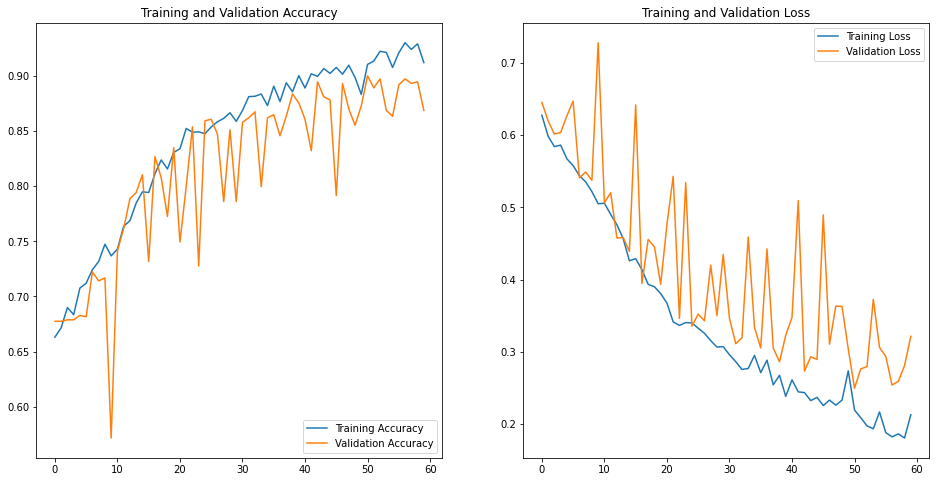

In [24]:
#results:
acc = history_binary_agumented.history['sparse_categorical_accuracy']
val_acc = history_binary_agumented.history['val_sparse_categorical_accuracy']

loss = history_binary_agumented.history['loss']
val_loss = history_binary_agumented.history['val_loss']

epochs_range = history_binary_agumented.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

Training and validation accuracy are much more alined when using agumented dataset for training the model.

In [25]:
test_loss, test_acc = cnn.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 0.2653624415397644
Accuracy on Testing data: 0.8890388607978821


In [12]:
y_pred = np.argmax(cnn.predict(imageTest/255), axis = 1)

In [13]:
print(confusion_matrix(binaryClassLabelTest, y_pred))

[[1116   96]
 [ 315 2177]]


Results show that classification is much better with agumented data set. The main reson is probably because it dosn't come to overfitting, we can see that in accuracy difference between training and validation of non-agumneted model. 

## Multi-class classification (non-agumented data)

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

In [2]:
#load pickle data
with open('Oxford-IIIT-Pet_Dics.p', 'rb') as f:
    pickle1 = pickle.load(f)

classDic=pickle1["classDic"]
filesDic=pickle1["filesDic"]

In [3]:
#setting nessesary variable
BASE_PATH = "images/"
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 125
LEARNING_RATE = 0.0001
PLOTS_DPI = 200

In [4]:
#Loading images to predefined shape and applying padding to avoid distortion.

imageData = []

for name in filesDic.keys():
    img = load_img(BASE_PATH+name)
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData.shape

(7390, 256, 256, 3)

In [6]:
#spliting images into training and testing array defined by pickle file
#adding target array(y) for multiclass classification and binary classification
imageTrain=[]
binaryClassLabelTrain=[]
multiClassLabelTrain=[]
imageTest=[]
binaryClassLabelTest=[]
multiClassLabelTest=[]
for i in range(0,len(filesDic)):
    if(list(filesDic.values())[i].get("foldTrain")):
        imageTrain.append(imageData[i])
        multiClassLabelTrain.append(list(filesDic.values())[i].get("target"))
        if(list(filesDic.values())[i].get("species")=='cat'):
            binaryClassLabelTrain.append(0)
        else:
            binaryClassLabelTrain.append(1)
    else:
        imageTest.append(imageData[i])
        multiClassLabelTest.append(list(filesDic.values())[i].get("target"))
        if(list(filesDic.values())[i].get("species")=='cat'):
            binaryClassLabelTest.append(0)
        else:
            binaryClassLabelTest.append(1)
        
imageTrain=np.array(imageTrain)
imageTest=np.array(imageTest)
binaryClassLabelTrain=np.array(binaryClassLabelTrain)
binaryClassLabelTest=np.array(binaryClassLabelTest)
multiClassLabelTest=np.array(multiClassLabelTest)
multiClassLabelTrain=np.array(multiClassLabelTrain)

print(imageTrain.shape)
print(binaryClassLabelTrain.shape)

(3686, 256, 256, 3)
(3686,)


In [8]:
#spliting test set into traing set and validation set
#i have chosen to split test image set, so we have more images to train model
imageTest, imageValidation, multiClassLabelTest, multiClassLabelValidation=train_test_split(imageTest,
                                                                                              multiClassLabelTest,
                                                                                              test_size=0.5,
                                                                                              random_state = 6,
                                                                                              stratify = multiClassLabelTest
                                                                                             )

In [9]:
#agumenting images using ImageDataGenerator and creating images tensors
train_gen_agumented = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data_agumented = train_gen_agumented.flow(x = imageTrain, y = multiClassLabelTrain, batch_size = BATCH_SIZE, shuffle = True)
len(train_data_agumented)

116

In [10]:
#using image data generator on all the data so we have all data as image tensor
train_gen = ImageDataGenerator(rescale = 1./255)
validation_data = train_gen.flow(x = imageValidation, y = multiClassLabelValidation, batch_size = BATCH_SIZE, shuffle = True)
len(validation_data)

58

In [11]:
train_gen = ImageDataGenerator(rescale = 1./255)
train_data = train_gen.flow(x = imageTrain, y = multiClassLabelTrain, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

116

In [12]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = imageTest, y = multiClassLabelTest, batch_size = BATCH_SIZE)
len(test_data)

58

In [13]:
#building a model
cnn=models.Sequential()
cnn.add(layers.Conv2D(32, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3)))
cnn.add(layers.Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.Conv2D(32, 4, padding = 'same'))
cnn.add(layers.Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
   
cnn.add(layers.Conv2D(64, 4, padding = 'same'))
cnn.add(layers.Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.BatchNormalization())
cnn.add(layers.Conv2D(64, 3, padding = 'same'))
cnn.add(layers.Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())

cnn.add(layers.Conv2D(128, 3, padding = 'same'))
cnn.add(layers.Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.Conv2D(128, 2, padding = 'same'))
cnn.add(layers.Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
        
cnn.add(layers.Conv2D(256, 2, padding = 'same'))
cnn.add(layers.Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())

cnn.add(layers.Flatten())
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(512, activation = 'sigmoid'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(256, activation = 'sigmoid'))
cnn.add(layers.Dropout(0.1))
cnn.add(layers.Dense(37, activation = 'softmax'))

cnn.compile(optimizer = Adam(LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      16416     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                    

In [14]:
#training the model with non-agumented data
history = cnn.fit(train_data, validation_data=validation_data, epochs = EPOCHS, verbose = 1)

Epoch 1/125
116/116 [==============================] - 952s 8s/step - loss: 3.6502 - sparse_categorical_accuracy: 0.0391 - val_loss: 3.6102 - val_sparse_categorical_accuracy: 0.0270
Epoch 2/125
116/116 [==============================] - 921s 8s/step - loss: 3.4878 - sparse_categorical_accuracy: 0.0760 - val_loss: 3.6106 - val_sparse_categorical_accuracy: 0.0346
Epoch 3/125
116/116 [==============================] - 917s 8s/step - loss: 3.3979 - sparse_categorical_accuracy: 0.0977 - val_loss: 3.5730 - val_sparse_categorical_accuracy: 0.0362
Epoch 4/125
116/116 [==============================] - 920s 8s/step - loss: 3.3081 - sparse_categorical_accuracy: 0.1191 - val_loss: 3.5355 - val_sparse_categorical_accuracy: 0.0535
Epoch 5/125
116/116 [==============================] - 918s 8s/step - loss: 3.2057 - sparse_categorical_accuracy: 0.1479 - val_loss: 3.4672 - val_sparse_categorical_accuracy: 0.0697
Epoch 6/125
116/116 [==============================] - 917s 8s/step - loss: 3.1135 - spars

Epoch 46/125
116/116 [==============================] - 920s 8s/step - loss: 0.0793 - sparse_categorical_accuracy: 0.9976 - val_loss: 3.8934 - val_sparse_categorical_accuracy: 0.1717
Epoch 47/125
116/116 [==============================] - 919s 8s/step - loss: 0.0549 - sparse_categorical_accuracy: 0.9992 - val_loss: 3.9205 - val_sparse_categorical_accuracy: 0.1782
Epoch 48/125
116/116 [==============================] - 930s 8s/step - loss: 0.0465 - sparse_categorical_accuracy: 0.9997 - val_loss: 3.9133 - val_sparse_categorical_accuracy: 0.1836
Epoch 49/125
116/116 [==============================] - 923s 8s/step - loss: 0.0364 - sparse_categorical_accuracy: 0.9997 - val_loss: 3.9778 - val_sparse_categorical_accuracy: 0.1728
Epoch 50/125
116/116 [==============================] - 922s 8s/step - loss: 0.0312 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.9834 - val_sparse_categorical_accuracy: 0.1841
Epoch 51/125
116/116 [==============================] - 919s 8s/step - loss: 0.0297 -

Epoch 91/125
116/116 [==============================] - 913s 8s/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9989 - val_loss: 4.7048 - val_sparse_categorical_accuracy: 0.1814
Epoch 92/125
116/116 [==============================] - 912s 8s/step - loss: 0.0258 - sparse_categorical_accuracy: 0.9962 - val_loss: 4.7202 - val_sparse_categorical_accuracy: 0.1722
Epoch 93/125
116/116 [==============================] - 911s 8s/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9986 - val_loss: 4.7621 - val_sparse_categorical_accuracy: 0.1798
Epoch 94/125
116/116 [==============================] - 910s 8s/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9951 - val_loss: 5.0529 - val_sparse_categorical_accuracy: 0.1636
Epoch 95/125
116/116 [==============================] - 913s 8s/step - loss: 0.0222 - sparse_categorical_accuracy: 0.9970 - val_loss: 4.9013 - val_sparse_categorical_accuracy: 0.1571
Epoch 96/125
116/116 [==============================] - 911s 8s/step - loss: 0.0257 -

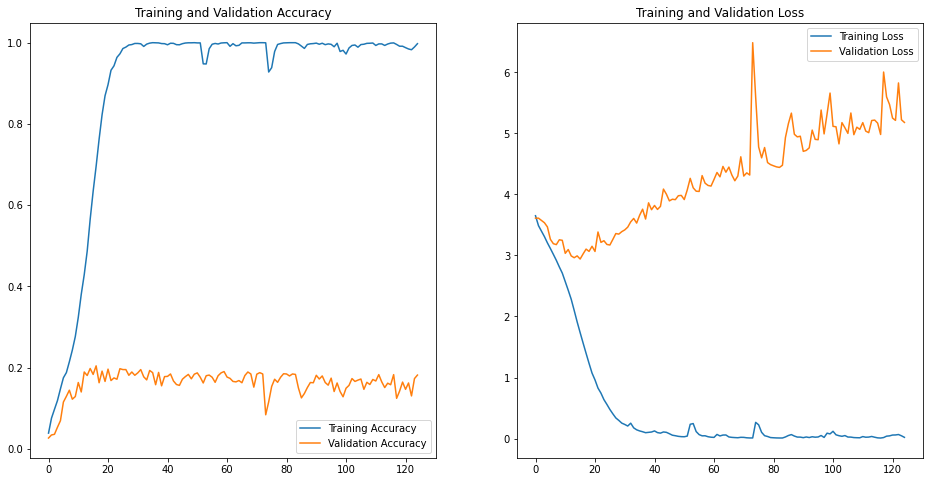

In [15]:
#Results:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

It is possible that overfitting may have caused low validation accuracy relative to training accuracy because we used nonaugmented data.

In [16]:
test_loss, test_acc = cnn.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 5.2146406173706055
Accuracy on Testing data: 0.17386609315872192


In [17]:
y_pred = np.argmax(cnn.predict(imageTest/255), axis = 1)

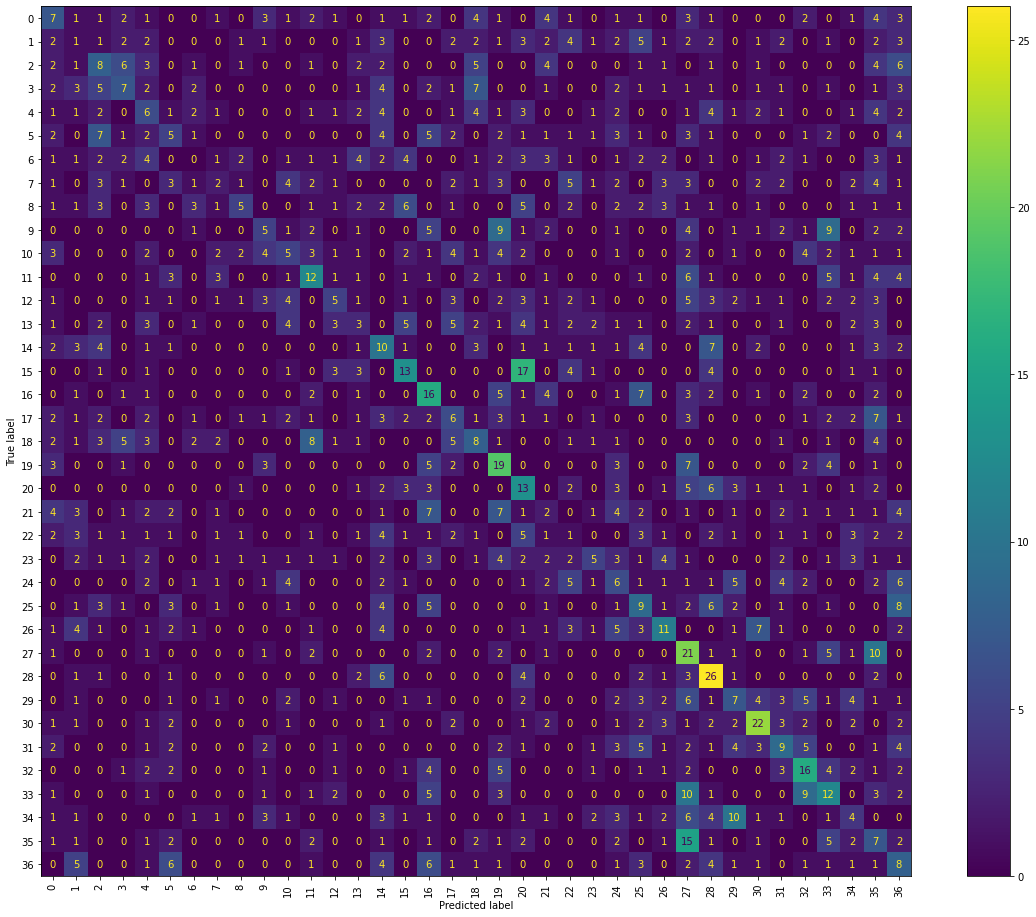

In [18]:
_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(multiClassLabelTest, y_pred),
                        display_labels = list(range(37))
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('confusion_matrix_multiclass.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

Accuracy is very low(17%) on test image set when using model with non-agumented data.

# Multi-class classification(agumneted data):

In [21]:
#building a model
cnn=models.Sequential()
cnn.add(layers.Conv2D(32, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3)))
cnn.add(layers.Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.Conv2D(32, 4, padding = 'same'))
cnn.add(layers.Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
   
cnn.add(layers.Conv2D(64, 4, padding = 'same'))
cnn.add(layers.Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.BatchNormalization())
cnn.add(layers.Conv2D(64, 3, padding = 'same'))
cnn.add(layers.Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())

cnn.add(layers.Conv2D(128, 3, padding = 'same'))
cnn.add(layers.Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
cnn.add(layers.Conv2D(128, 2, padding = 'same'))
cnn.add(layers.Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())
        
cnn.add(layers.Conv2D(256, 2, padding = 'same'))
cnn.add(layers.Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
cnn.add(layers.MaxPooling2D())

cnn.add(layers.Flatten())
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(512, activation = 'sigmoid'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(256, activation = 'sigmoid'))
cnn.add(layers.Dropout(0.1))
cnn.add(layers.Dense(37, activation = 'softmax'))

cnn.compile(optimizer = Adam(LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      16416     
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      16416     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [22]:
#training the model with agumented data
history_agumented = cnn.fit(train_data_agumented, validation_data=validation_data, epochs = EPOCHS, verbose = 1)

Epoch 1/125
116/116 [==============================] - 963s 8s/step - loss: 3.6604 - sparse_categorical_accuracy: 0.0350 - val_loss: 3.6129 - val_sparse_categorical_accuracy: 0.0270
Epoch 2/125
116/116 [==============================] - 969s 8s/step - loss: 3.5439 - sparse_categorical_accuracy: 0.0583 - val_loss: 3.5945 - val_sparse_categorical_accuracy: 0.0373
Epoch 3/125
116/116 [==============================] - 1008s 9s/step - loss: 3.4766 - sparse_categorical_accuracy: 0.0705 - val_loss: 3.5617 - val_sparse_categorical_accuracy: 0.0405
Epoch 4/125
116/116 [==============================] - 926s 8s/step - loss: 3.4196 - sparse_categorical_accuracy: 0.0906 - val_loss: 3.5179 - val_sparse_categorical_accuracy: 0.0427
Epoch 5/125
116/116 [==============================] - 927s 8s/step - loss: 3.3529 - sparse_categorical_accuracy: 0.1055 - val_loss: 3.3424 - val_sparse_categorical_accuracy: 0.0977
Epoch 6/125
116/116 [==============================] - 925s 8s/step - loss: 3.2908 - spar

Epoch 46/125
116/116 [==============================] - 929s 8s/step - loss: 1.7401 - sparse_categorical_accuracy: 0.4894 - val_loss: 2.4017 - val_sparse_categorical_accuracy: 0.3245
Epoch 47/125
116/116 [==============================] - 932s 8s/step - loss: 1.7219 - sparse_categorical_accuracy: 0.4913 - val_loss: 2.5336 - val_sparse_categorical_accuracy: 0.3105
Epoch 48/125
116/116 [==============================] - 931s 8s/step - loss: 1.6912 - sparse_categorical_accuracy: 0.4962 - val_loss: 2.5912 - val_sparse_categorical_accuracy: 0.3083
Epoch 49/125
116/116 [==============================] - 932s 8s/step - loss: 1.6672 - sparse_categorical_accuracy: 0.5073 - val_loss: 2.5532 - val_sparse_categorical_accuracy: 0.2797
Epoch 50/125
116/116 [==============================] - 931s 8s/step - loss: 1.6498 - sparse_categorical_accuracy: 0.5062 - val_loss: 2.6611 - val_sparse_categorical_accuracy: 0.2694
Epoch 51/125
116/116 [==============================] - 930s 8s/step - loss: 1.6164 -

Epoch 91/125
116/116 [==============================] - 931s 8s/step - loss: 0.9717 - sparse_categorical_accuracy: 0.6994 - val_loss: 2.3232 - val_sparse_categorical_accuracy: 0.3790
Epoch 92/125
116/116 [==============================] - 936s 8s/step - loss: 0.9781 - sparse_categorical_accuracy: 0.6856 - val_loss: 2.3231 - val_sparse_categorical_accuracy: 0.3769
Epoch 93/125
116/116 [==============================] - 930s 8s/step - loss: 0.9520 - sparse_categorical_accuracy: 0.7010 - val_loss: 1.9720 - val_sparse_categorical_accuracy: 0.4379
Epoch 94/125
116/116 [==============================] - 933s 8s/step - loss: 0.9452 - sparse_categorical_accuracy: 0.7122 - val_loss: 2.3313 - val_sparse_categorical_accuracy: 0.3871
Epoch 95/125
116/116 [==============================] - 940s 8s/step - loss: 0.9477 - sparse_categorical_accuracy: 0.7116 - val_loss: 1.9695 - val_sparse_categorical_accuracy: 0.4611
Epoch 96/125
116/116 [==============================] - 930s 8s/step - loss: 0.9381 -

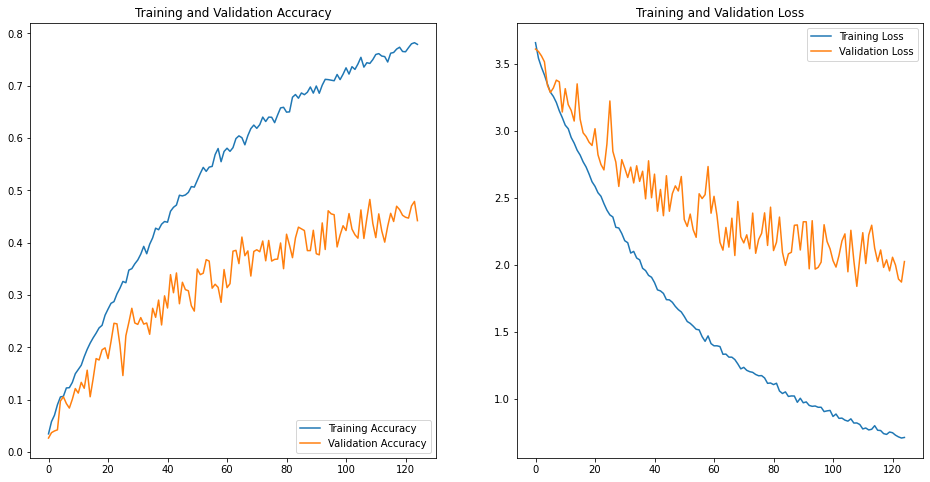

In [23]:
acc = history_agumented.history['sparse_categorical_accuracy']
val_acc = history_agumented.history['val_sparse_categorical_accuracy']

loss = history_agumented.history['loss']
val_loss = history_agumented.history['val_loss']

epochs_range = history_agumented.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

Validation accuracy improved in model with agumented data.

In [24]:
test_loss, test_acc = cnn.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 2.0035905838012695
Accuracy on Testing data: 0.47516199946403503


In [25]:
y_pred = np.argmax(cnn.predict(imageTest/255), axis = 1)

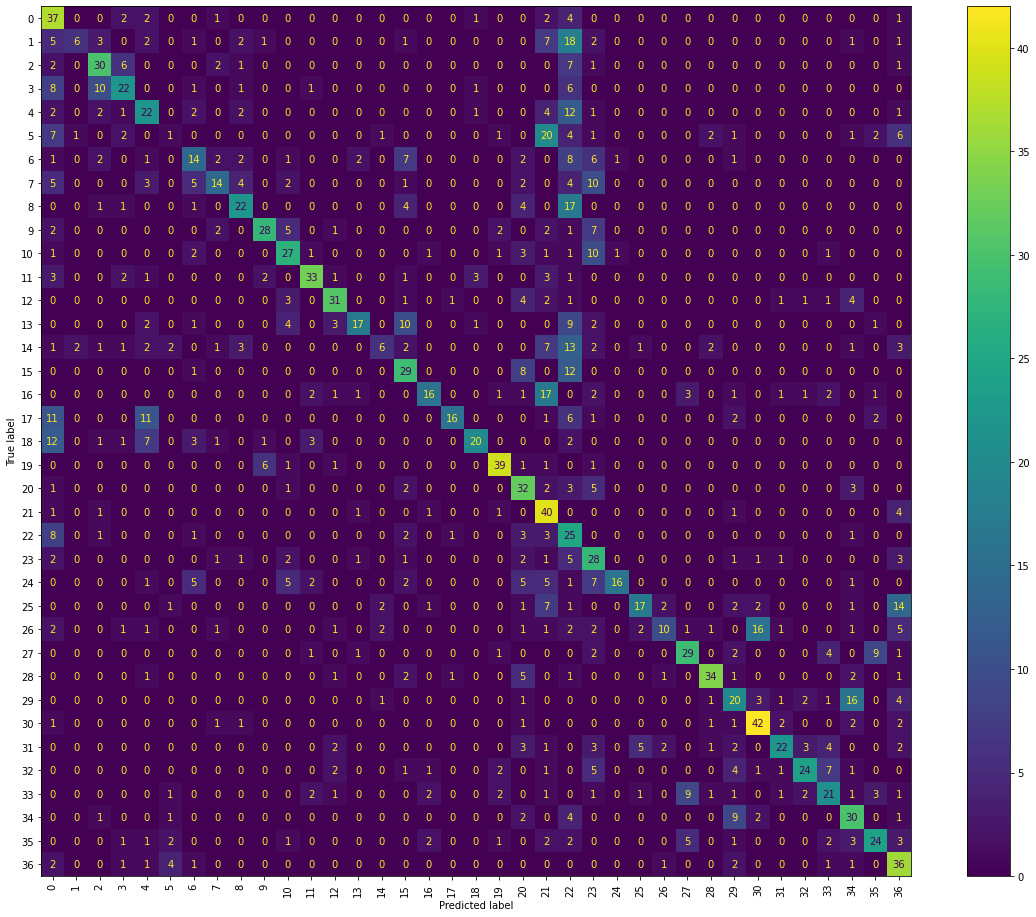

In [26]:
_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(multiClassLabelTest, y_pred),
                        display_labels = list(range(37))
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('confusion_matrix_multiclass.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

Results are better with agumented data, but they are not as good as using pretrained models. Even tho acuracy on testing data is 47% that is not that bad considering there are 37 classes. Using this same model we could improve results by spliting training and testing data set diffrently from pickle(50/50) data provided, so there are more images used for training and less for testing.

## Transfer learning (non-agumented data):

In [21]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input


In [22]:
#loading pickle file
with open('Oxford-IIIT-Pet_Dics.p', 'rb') as f:
    pickle1 = pickle.load(f)

classDic=pickle1["classDic"]
filesDic=pickle1["filesDic"]

In [23]:
#setting necessary variables
BASE_PATH = "images/"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001
PLOTS_DPI = 200

In [24]:
#Loading images and applying padding to avoid distortion.

imageData = []

for name in filesDic.keys():
    img = load_img(BASE_PATH+name)
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData.shape

(7390, 224, 224, 3)

In [40]:
#spliting images into training and testing array defined by pickle file
#adding target array(y) for multiclass classification and binary classification
imageTrain=[]
binaryClassLabelTrain=[]
multiClassLabelTrain=[]
imageTest=[]
binaryClassLabelTest=[]
multiClassLabelTest=[]
for i in range(0,len(filesDic)):
    if(list(filesDic.values())[i].get("foldTrain")):
        imageTrain.append(imageData[i])
        multiClassLabelTrain.append(list(filesDic.values())[i].get("target"))
        if(list(filesDic.values())[i].get("species")=='cat'):
            binaryClassLabelTrain.append(0)
        else:
            binaryClassLabelTrain.append(1)
    else:
        imageTest.append(imageData[i])
        multiClassLabelTest.append(list(filesDic.values())[i].get("target"))
        if(list(filesDic.values())[i].get("species")=='cat'):
            binaryClassLabelTest.append(0)
        else:
            binaryClassLabelTest.append(1)
        
imageTrain=np.array(imageTrain)
imageTest=np.array(imageTest)
binaryClassLabelTrain=np.array(binaryClassLabelTrain)
binaryClassLabelTest=np.array(binaryClassLabelTest)
multiClassLabelTest=np.array(multiClassLabelTest)
multiClassLabelTrain=np.array(multiClassLabelTrain)

print(imageTrain.shape)
print(binaryClassLabelTrain.shape)

(3686, 224, 224, 3)
(3686,)


In [42]:
#spliting trainig set into traing set and validation set
imageTrain, imageValidation, multiClassLabelTrain, multiClassLabelValidation=train_test_split(imageTrain,
                                                                                              multiClassLabelTrain,
                                                                                              test_size=0.2,
                                                                                              random_state = 5,
                                                                                              stratify = multiClassLabelTrain
                                                                                             )
#transforming labels to categorical
multiClassLabelTrain=to_categorical(multiClassLabelTrain)
multiClassLabelTest_noncategorical=multiClassLabelTest
multiClassLabelTest=to_categorical(multiClassLabelTest)
multiClassLabelValidation=to_categorical(multiClassLabelValidation)

In [29]:
#agumenting images using ImageDataGenerator
train_gen_agumented = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data_agumented = train_gen_agumented.flow(x = imageTrain, y = multiClassLabelTrain, batch_size = BATCH_SIZE, shuffle = True)
len(train_data_agumented)

93

In [30]:
#using image data generator on all the data so we have all data as image tensor
train_gen = ImageDataGenerator(rescale = 1./255)
validation_data = train_gen.flow(x = imageValidation, y = multiClassLabelValidation, batch_size = BATCH_SIZE, shuffle = True)
len(validation_data)

24

In [31]:
train_gen = ImageDataGenerator(rescale = 1./255)
train_data = train_gen.flow(x = imageTrain, y = multiClassLabelTrain, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

93

In [32]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = imageTest, y = multiClassLabelTest, batch_size = BATCH_SIZE)
len(test_data)

116

In [33]:
#Using MobileNetV2 model with imagenet weights
cnnBase=MobileNetV2(weights="imagenet",include_top=False, input_shape=(224,224,3))
cnnBase.trainable=False #Freeze

cnn=keras.models.Sequential()
cnn.add(cnnBase)
cnn.add(keras.layers.AveragePooling2D(pool_size=(2,2),strides=2))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dropout(.3))
cnn.add(keras.layers.Dense(128,activation="relu"))
cnn.add(keras.layers.Dropout(.3))
cnn.add(keras.layers.Dense(37, activation="softmax"))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_2 (Averag  (None, 3, 3, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 11520)             0         
                                                                 
 dropout_4 (Dropout)         (None, 11520)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               1474688   
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [34]:
cnn.compile(loss="categorical_crossentropy",optimizer="nadam",metrics=["categorical_accuracy"])
#training a model with  non-agumented data
history_tl=cnn.fit(train_data, validation_data=validation_data,steps_per_epoch=40,validation_steps=20,epochs=40)

Epoch 1/40
40/40 [==============================] - 63s 1s/step - loss: 2.4086 - categorical_accuracy: 0.3842 - val_loss: 0.9679 - val_categorical_accuracy: 0.7125
Epoch 2/40
40/40 [==============================] - 49s 1s/step - loss: 0.9079 - categorical_accuracy: 0.7453 - val_loss: 0.7131 - val_categorical_accuracy: 0.7875
Epoch 3/40
40/40 [==============================] - 48s 1s/step - loss: 0.7586 - categorical_accuracy: 0.7719 - val_loss: 0.5785 - val_categorical_accuracy: 0.8125
Epoch 4/40
40/40 [==============================] - 44s 1s/step - loss: 0.4784 - categorical_accuracy: 0.8539 - val_loss: 0.5141 - val_categorical_accuracy: 0.8453
Epoch 5/40
40/40 [==============================] - 48s 1s/step - loss: 0.4606 - categorical_accuracy: 0.8594 - val_loss: 0.5266 - val_categorical_accuracy: 0.8359
Epoch 6/40
40/40 [==============================] - 56s 1s/step - loss: 0.4194 - categorical_accuracy: 0.8742 - val_loss: 0.4671 - val_categorical_accuracy: 0.8516
Epoch 7/40
40/40

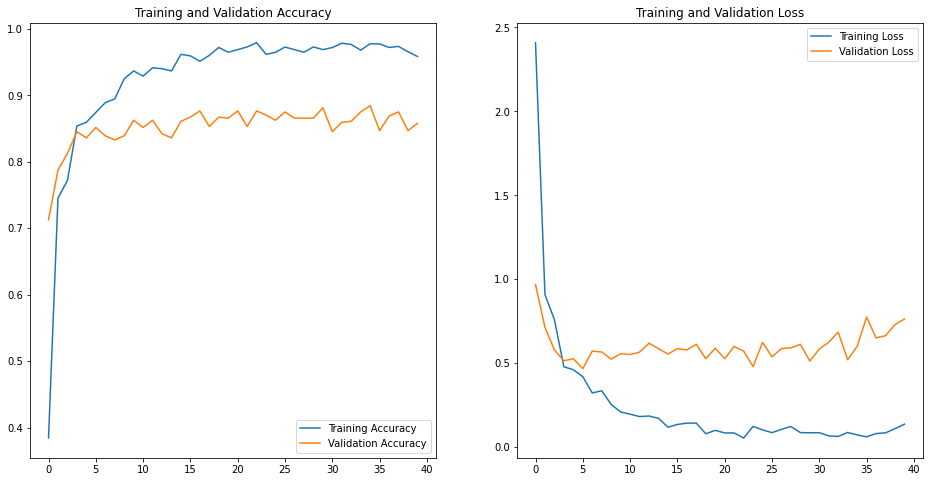

In [36]:
#results:
acc = history_tl.history['categorical_accuracy']
val_acc = history_tl.history['val_categorical_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

epochs_range = history_tl.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

Validation accuracy is much lower than training accuracy which may suggest some overfitting is happening.

In [37]:
test_loss, test_acc = cnn.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 0.9140673279762268
Accuracy on Testing data: 0.812904953956604


In [38]:
y_pred = np.argmax(cnn.predict(imageTest/255), axis = 1)

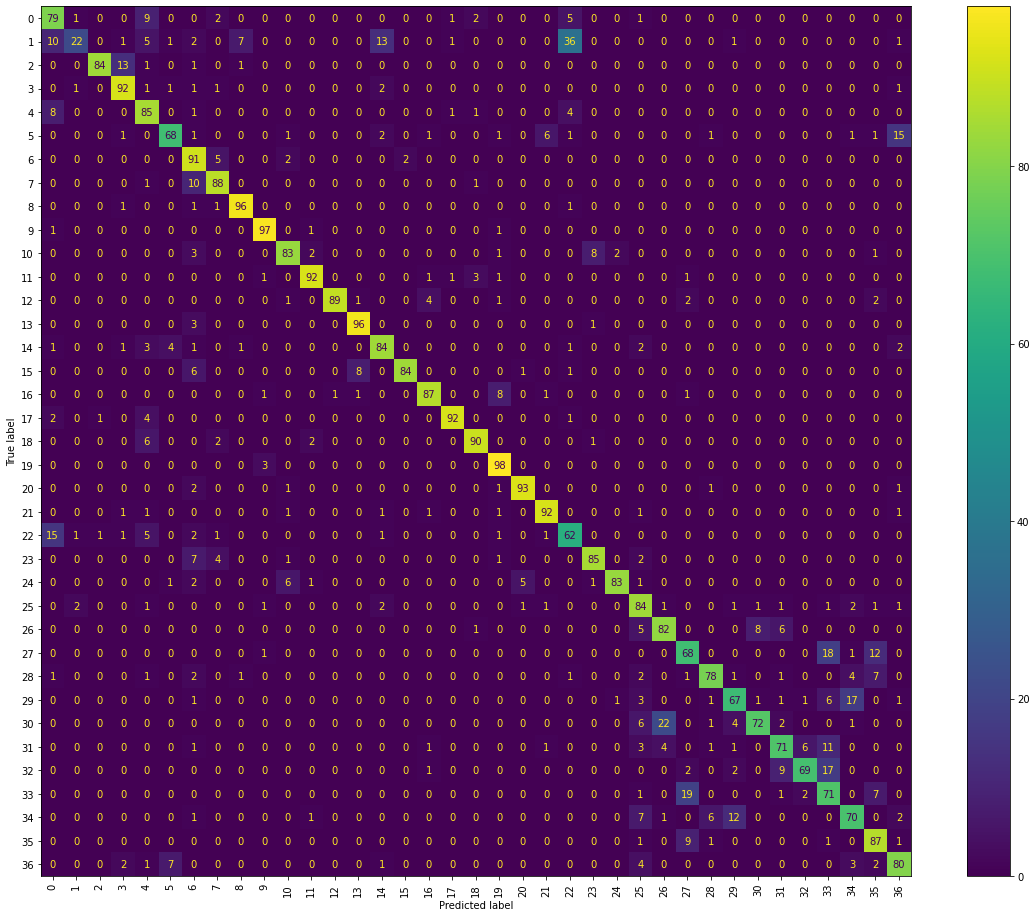

In [43]:
_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(multiClassLabelTest_noncategorical, y_pred),
                        display_labels = list(range(37))
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('confusion_matrix_multiclass.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

Results are better than using our own model. We can see that most of the erros are in images with cats.

## Transfer learning (Agumneted data):

In [53]:
#Using MobileNetV2 model with imagenet weights
cnnBase=MobileNetV2(weights="imagenet",include_top=False, input_shape=(224,224,3))
cnnBase.trainable=False

cnn=keras.models.Sequential()
cnn.add(cnnBase)
cnn.add(keras.layers.AveragePooling2D(pool_size=(2,2),strides=2))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dropout(.3))
cnn.add(keras.layers.Dense(128,activation="relu"))
cnn.add(keras.layers.Dropout(.3))
cnn.add(keras.layers.Dense(37, activation="softmax"))

cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_4 (Averag  (None, 3, 3, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten_6 (Flatten)         (None, 11520)             0         
                                                                 
 dropout_12 (Dropout)        (None, 11520)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               1474688   
                                                                 
 dropout_13 (Dropout)        (None, 128)              

In [54]:
cnn.compile(loss="categorical_crossentropy",optimizer="nadam",metrics=["categorical_accuracy"])
#training a model with  agumented data
history_tl_agumented=cnn.fit(train_data_agumented, validation_data=validation_data,steps_per_epoch=40,validation_steps=20,epochs=40)

Epoch 1/40
40/40 [==============================] - 2719s 70s/step - loss: 2.7535 - categorical_accuracy: 0.3031 - val_loss: 1.1105 - val_categorical_accuracy: 0.6609
Epoch 2/40
40/40 [==============================] - 5817s 147s/step - loss: 1.4336 - categorical_accuracy: 0.5961 - val_loss: 0.7131 - val_categorical_accuracy: 0.7547
Epoch 3/40
40/40 [==============================] - 2440s 62s/step - loss: 1.1762 - categorical_accuracy: 0.6605 - val_loss: 0.6186 - val_categorical_accuracy: 0.8047
Epoch 4/40
40/40 [==============================] - 3380s 85s/step - loss: 1.0003 - categorical_accuracy: 0.7102 - val_loss: 0.6586 - val_categorical_accuracy: 0.7906
Epoch 5/40
40/40 [==============================] - 1582s 40s/step - loss: 0.9489 - categorical_accuracy: 0.7268 - val_loss: 0.6254 - val_categorical_accuracy: 0.8047
Epoch 6/40
40/40 [==============================] - 1398s 35s/step - loss: 0.9286 - categorical_accuracy: 0.7332 - val_loss: 0.5496 - val_categorical_accuracy: 0.82

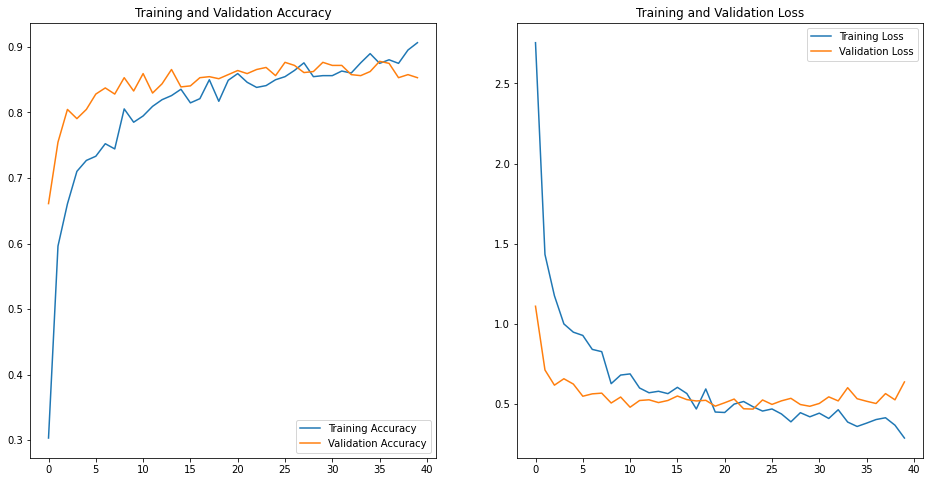

In [55]:
#results:
acc = history_tl_agumented.history['categorical_accuracy']
val_acc = history_tl_agumented.history['val_categorical_accuracy']

loss = history_tl_agumented.history['loss']
val_loss = history_tl_agumented.history['val_loss']

epochs_range = history_tl_agumented.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

Validation accuracy slightly improved with agumented data and traing accuracy is more related with validation accuracy.

In [56]:
test_loss, test_acc = cnn.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 0.7730559706687927
Accuracy on Testing data: 0.8201943635940552


In [57]:
y_pred = np.argmax(cnn.predict(imageTest/255), axis = 1)

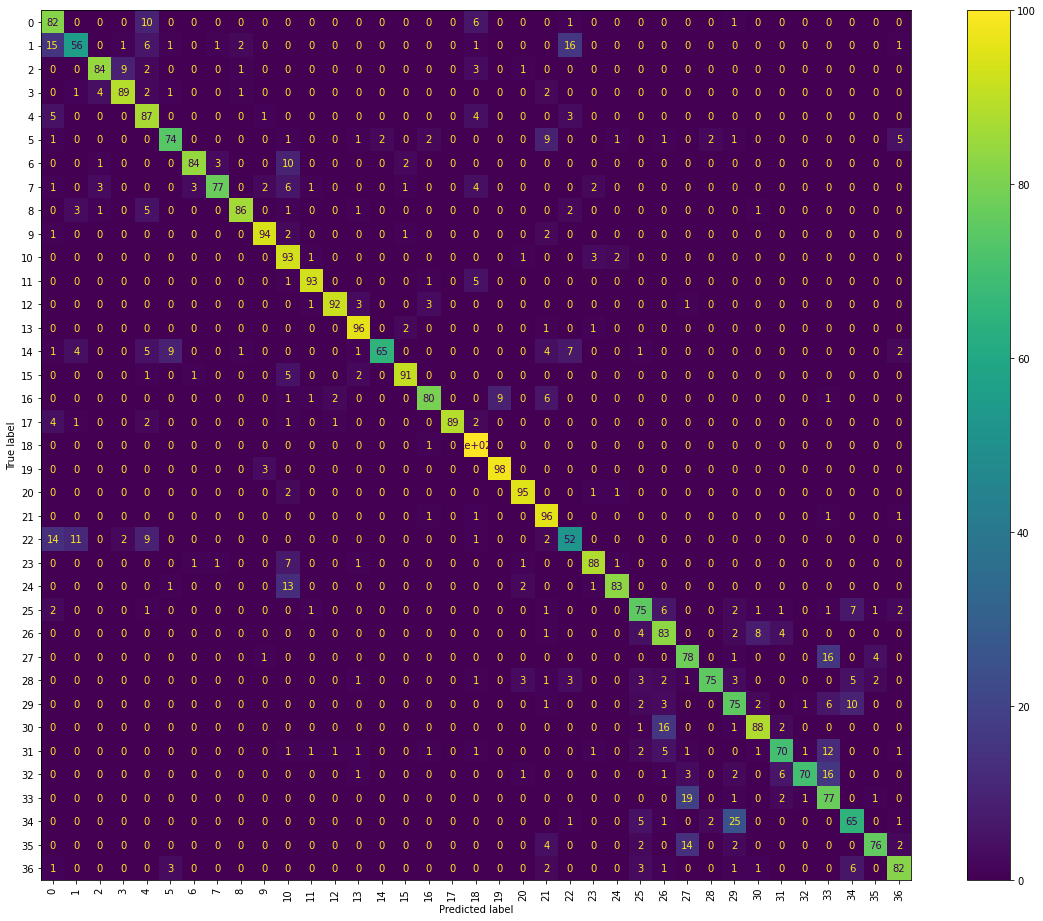

In [58]:
_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(multiClassLabelTest_noncategorical, y_pred),
                        display_labels = list(range(37))
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('confusion_matrix_multiclass.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

Even tho we had a litle better traing accuracy, results just slightly improved with agumented data. We can see that data agumentation dosn't play such big role with transfer learning in comperison with models that we build. One of the main advantage along with good results when using transfer learning, is saving a lot of time on training and developing a model. 